In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
bs = 200
max_features = 100

In [4]:
save_file_name = os.path.join("..", "data", "temp_spam_data.csv")

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            text_data.append(row)
else:
    zip_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read("SMSSpamCollection")
    text_data = file.decode()
    text_data = text_data.encode("ascii", errors="ignore")
    text_data = text_data.decode().split("\n")
    text_data = [x.split("\t") for x in text_data if len(x) >= 1]
    
    with open(save_file_name, "w") as f:
        writer = csv.writer(f)
        writer.writerows(text_data)
        
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x == "spam" else 0 for x in target]

In [5]:
texts = [x.lower() for x in texts]
texts = ["".join(c for c in x if c not in string.punctuation) for x in texts]
texts = ["".join(c for c in x if c not in "0123456789") for x in texts]
texts = [" ".join(x.split()) for x in texts]

In [8]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

In [10]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0],
                                 round(sparse_tfidf_texts.shape[0] * 0.8),
                                 replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [22]:
with tf.Session() as sess:
    A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
    b = tf.Variable(tf.random_normal(shape=[1, 1]))
    x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    model_output = tf.add(tf.matmul(x_data, A), b)
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=model_output,
        labels=y_target
    ))
    prediction = tf.round(tf.sigmoid(model_output))
    prediction_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
    accuracy = tf.reduce_mean(prediction_correct)
    
    my_opt = tf.train.GradientDescentOptimizer(0.0025)
    train_step = my_opt.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    i_data = []
    for i in range(10000):
        rand_index = np.random.choice(texts_train.shape[0], size=bs)
        rand_x = texts_train[rand_index].todense()
        rand_y = np.transpose([target_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        
        if (i + 1) % 100 == 0:
            i_data.append(i + 1)
            train_loss_temp = sess.run(loss, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            train_loss.append(train_loss_temp)
            
            test_loss_temp = sess.run(loss, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            test_loss.append(test_loss_temp)
            
            train_acc_temp = sess.run(accuracy, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            train_acc.append(train_acc_temp)
            
            test_acc_temp = sess.run(accuracy, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            test_acc.append(test_acc_temp)
        
        if (i + 1) % 500 == 0:
            acc_and_loss = [i + 1, train_loss_temp, test_loss_temp,
                            train_acc_temp, test_acc_temp]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}).\n\t\t   Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.79 (0.79).
		   Train Acc (Test Acc): 0.55 (0.55)
Generation # 1000. Train Loss (Test Loss): 0.53 (0.53).
		   Train Acc (Test Acc): 0.81 (0.81)
Generation # 1500. Train Loss (Test Loss): 0.58 (0.58).
		   Train Acc (Test Acc): 0.70 (0.70)
Generation # 2000. Train Loss (Test Loss): 0.54 (0.54).
		   Train Acc (Test Acc): 0.74 (0.74)
Generation # 2500. Train Loss (Test Loss): 0.56 (0.56).
		   Train Acc (Test Acc): 0.77 (0.77)
Generation # 3000. Train Loss (Test Loss): 0.43 (0.43).
		   Train Acc (Test Acc): 0.82 (0.82)
Generation # 3500. Train Loss (Test Loss): 0.49 (0.49).
		   Train Acc (Test Acc): 0.78 (0.78)
Generation # 4000. Train Loss (Test Loss): 0.49 (0.49).
		   Train Acc (Test Acc): 0.82 (0.82)
Generation # 4500. Train Loss (Test Loss): 0.43 (0.43).
		   Train Acc (Test Acc): 0.84 (0.84)
Generation # 5000. Train Loss (Test Loss): 0.45 (0.45).
		   Train Acc (Test Acc): 0.87 (0.87)
Generation # 5500. Train Loss (Test Loss): 0.41 (0.

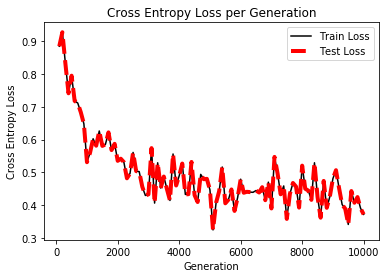

In [23]:
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

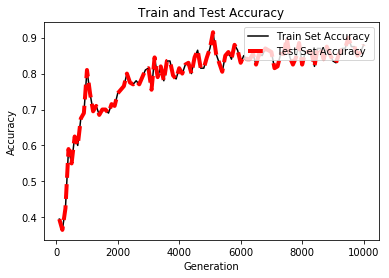

In [24]:
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()